In [1]:
import os

os.chdir("../../")

import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.data_handling import ingestion

sns.set_theme(context="paper", font_scale=2.0, style="whitegrid")

In [2]:
ts_data = ingestion.read_combined().dropna()

d:\anaconda3\envs\ba\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\anaconda3\envs\ba\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\anaconda3\envs\ba\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\anaconda3\envs\ba\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [3]:
X = ts_data.drop(columns=["consumption", "temperature"])
X_static_regressors = X.copy()
X_static_regressors.loc["2021-01-01":, X_static_regressors.columns.drop("temperature_capped")] = float("nan")
X_static_regressors = X_static_regressors.fillna(method="ffill")

y = ts_data["consumption"]

X_train = X[:"2020"]
X_test = X["2021":]
y_train = y[:"2020"]
y_test = y["2021":]

In [4]:
# Model
model = xgb.XGBRegressor(
    n_estimators=1000,
    max_depth=1,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    random_state=42,
)

# Train
model = model.fit(
    X_train,
    y_train,
)

# Predict
y_pred = model.predict(X_test)

In [5]:
modelled_consumption = pd.Series(model.predict(X), index=X.index, name="modelled_consumption")
modelled_consumption_static_regressors = pd.Series(model.predict(X_static_regressors), index=X.index, name="modelled_consumption_static_regressors")

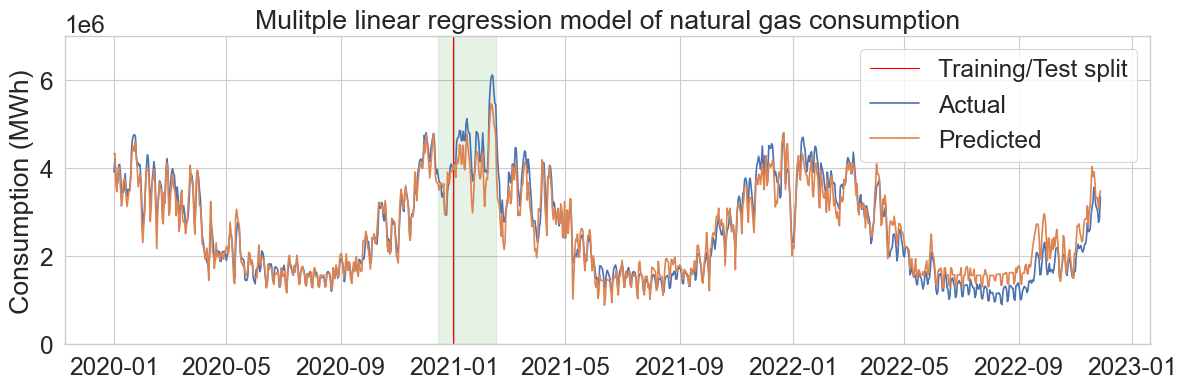

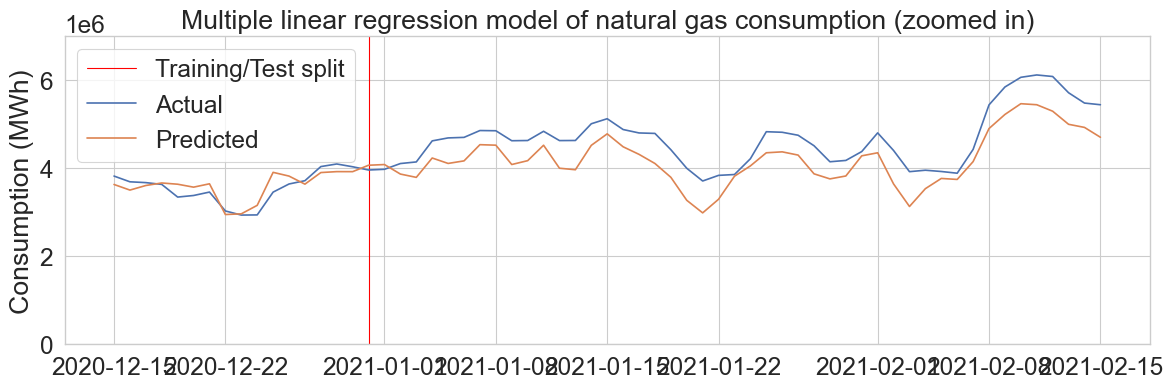

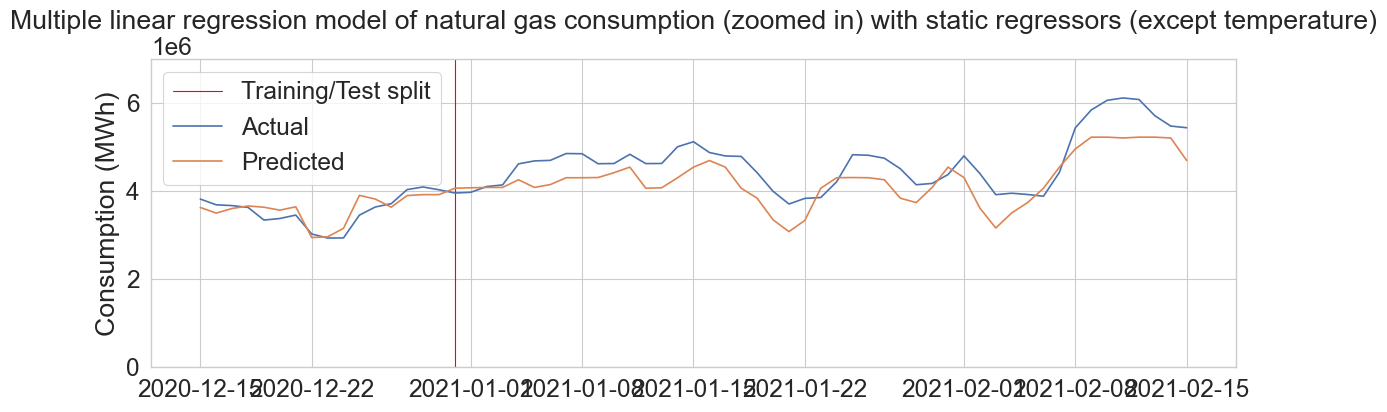

In [6]:
# Plot 1 - multiple years
fig, ax = plt.subplots(figsize=(14, 4))

ax.axvline(
    pd.Timestamp("2020-12-31"), color="red", linewidth=0.8, label="Training/Test split"
)
ax.axvspan(
    pd.Timestamp("2020-12-15"), pd.Timestamp("2021-02-15"), color="green", alpha=0.1
)
ax.plot(y["2020":], label="Actual")
ax.plot(modelled_consumption["2020":], label="Predicted")
ax.set_ylabel("Consumption (MWh)")
ax.legend()
ax.set_title("Mulitple linear regression model of natural gas consumption")
ax.set_ylim(0, 7 * 10**6)

# Save plot
fig.savefig("diagrams/modelling_004_001.svg", format="svg", bbox_inches="tight")

# Plot 2 - zoomed in
fig, ax2 = plt.subplots(figsize=(14, 4))

ax2.axvline(
    pd.Timestamp("2020-12-31"), color="red", linewidth=0.8, label="Training/Test split"
)
ax2.plot(y["2020-12-15":"2021-02-15"], label="Actual")
ax2.plot(modelled_consumption["2020-12-15":"2021-02-15"], label="Predicted")
ax2.set_ylabel("Consumption (MWh)")
ax2.legend()
ax2.set_title("Multiple linear regression model of natural gas consumption (zoomed in)")
ax2.set_ylim(0, 7 * 10**6)

# Save plot
fig.savefig("diagrams/modelling_004_002.svg", format="svg", bbox_inches="tight")

# Plot 3 - zoomed in with static regressors
fig, ax3 = plt.subplots(figsize=(14, 4))

ax3.axvline(
    pd.Timestamp("2020-12-31"), color="red", linewidth=0.8, label="Training/Test split"
)
ax3.plot(y["2020-12-15":"2021-02-15"], label="Actual")
ax3.plot(
    modelled_consumption_static_regressors["2020-12-15":"2021-02-15"], label="Predicted"
)
ax3.set_ylabel("Consumption (MWh)")
ax3.legend()
ax3.set_title(
    "Multiple linear regression model of natural gas consumption (zoomed in) with static regressors (except temperature)"
)
ax3.set_ylim(0, 7 * 10**6)

# Save plot
fig.savefig("diagrams/modelling_004_003.svg", format="svg", bbox_inches="tight")

In [7]:
# Mean Absolute Percentage Error (MAPE) for 60days after training data cutoff
mape = (
    abs(y["2021-01-01":"2021-02-28"] - modelled_consumption["2021-01-01":"2021-02-28"])
    / y["2021-01-01":"2021-02-28"]
).mean() * 100

mape_static_regressors = (
    abs(y["2021-01-01":"2021-02-28"] - modelled_consumption_static_regressors["2021-01-01":"2021-02-28"])
    / y["2021-01-01":"2021-02-28"]
).mean() * 100

mape_static_regressors_14days = (
    abs(y["2021-01-01":"2021-01-14"] - modelled_consumption_static_regressors["2021-01-01":"2021-01-14"])
    / y["2021-01-01":"2021-01-14"]
).mean() * 100

print(f"MAPE: {mape:.2f}%")
print(f"MAPE (static regressors): {mape_static_regressors:.2f}%")
print(f"MAPE (static regressors, 14 days): {mape_static_regressors_14days:.2f}%")

MAPE: 11.00%
MAPE (static regressors): 9.90%
MAPE (static regressors, 14 days): 8.19%
